# Create a NetworkX street network from OpenStreetMap

- https://graph-tool.skewed.de/static/doc/centrality.html

In [1]:
import osmnx, networkx as nx, matplotlib.pyplot as plt, pandas as pd
%matplotlib inline

In [2]:
osmnx.init(file_log=True)

## Configure the script

In [3]:
# San Francisco
north = 37.81
south = 37.76
east = -122.40
west = -122.45

# Mark Hopkins Hotel in SF
location_point = (37.791427, -122.410018)

In [4]:
# Berkeley
north = 37.864672
south = 37.857659
east = -122.268853
west = -122.278337

# Tim Moellering Field
location_point = (37.860157, -122.271552)

## Download and process the data

Three ways to download data
  1. pass a bounding box
  2. pass a (lat,lon) point and great circle distance in meters. this creates a bounding box, downloads the network, then prunes it by the bounding box.
  3. pass a (lat,lon) point and network distance in meters. this creates a bounding box, downloads the network, then prunes it by network distance.
  4. pass an address and distance (great circle or network) in meters. this geocodes the address, creates a bounding box, downloads the network, then prunes it by network distance or bounding box.

In [5]:
# graph from a bounding box
G1 = osmnx.graph_from_bbox(north, south, east, west)
len(G1.nodes())

256

In [6]:
nx.write_gml(G1, '{}/test.gml'.format(osmnx._data_folder))

In [7]:
# from some point, with bounding box of N, S, E, W each 1 km from point
G2 = osmnx.graph_from_point(location_point, distance=1000, distance_type='bbox')
len(G2.nodes())

2718

In [8]:
# same point, but create graph only of nodes within 500m along the network from the point
G3 = osmnx.graph_from_point(location_point, distance=500, distance_type='network')
len(G3.nodes())

257

In [9]:
# graph from address, including only nodes within 500m along the network from the address
G, location_point = osmnx.graph_from_address(address='Oakland, California', 
                                       distance=500, 
                                       distance_type='network', 
                                       return_coords=True)
len(G.nodes())

468

In [10]:
# save graph to disk
#nx.write_gpickle(G, '{}/network.gpickle'.format(osmnx._data_folder))

## Define functions to get colors for different node and edge types

In [11]:
pd.Series([node['highway'] for node in G.node.values()]).value_counts()

                   370
crossing            66
traffic_signals     28
stop                 3
turning_circle       1
dtype: int64

In [12]:
def get_node_color(node):
    hwy = node['highway']
    if hwy is None:
        return 'b'
    elif hwy == 'crossing':
        return 'r'
    elif hwy == 'stop':
        return 'g'
    elif hwy == 'traffic_signals':
        return 'c'
    else:
        return 'k'

In [13]:
pd.Series([edge['highway'] for _, _, edge in G.edges(data=True)]).value_counts()

    541
dtype: int64

In [14]:
def get_edge_color(edge_details):
    hwy = edge_details['highway']
    if hwy in ['primary', 'secondary', 'tertiary', 'residential']:
        return 'b'
    elif hwy in ['footway', 'steps', 'path', 'pedestrian', 'track', 'cycleway']:
        return 'g'
    elif hwy in ['primary_link', 'secondary_link', 'tertiary_link']:
        return 'b'
    elif hwy in ['service']:
        return 'm'
    elif hwy in ['unclassified']:
        return 'b'
    else:
        return 'r'

## Plot it

In [15]:
fig_width = 8
bbox_aspect_ratio = (north-south)/(east-west)

xmin = min(nx.get_node_attributes(G,'lon').values())
xmax = max(nx.get_node_attributes(G,'lon').values())
ymin = min(nx.get_node_attributes(G,'lat').values())
ymax = max(nx.get_node_attributes(G,'lat').values())

In [16]:
centermost_node = osmnx.get_nearest_node(G, location_point)

In [17]:
lons = [float(node['lon']) for node in G.node.values()]
lats = [float(node['lat']) for node in G.node.values()]
node_colors = [get_node_color(node) for node in G.node.values()]

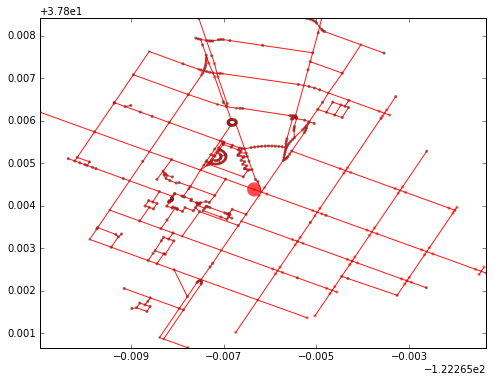

In [18]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width * bbox_aspect_ratio))
for u, v, edge_details in G.edges(data=True):
    x = (G.node[u]['lon'], G.node[v]['lon'])
    y = (G.node[u]['lat'], G.node[v]['lat'])
    color = get_edge_color(edge_details)
    ax.plot(x, y, color=color, linewidth=1, alpha=0.9)

ax.scatter(lons, lats, s=10, c=node_colors, alpha=0.5, edgecolor='none')

ax.scatter(G.node[centermost_node]['lon'], 
           G.node[centermost_node]['lat'], 
           s=200, c='r', alpha=0.7, edgecolor='none')

ax.set_ylim((ymin, ymax))
ax.set_xlim((xmin, xmax))

#fig.savefig('{}/network.png'.format(osmnx._imgs_folder), dpi=200)
plt.show()

## Calculate the network path from the centermost node to some other node

In [19]:
origin_node = centermost_node
destination_node = G.nodes()[0]
origin_node, destination_node

(766, 3)

In [20]:
shortest_path = nx.shortest_path(G, origin_node, destination_node)
str(shortest_path)

'[766, 368, 770, 705, 989, 239, 610, 642, 288, 545, 3]'

## Plot this network path

In [21]:
origin_destination_lats = (G.node[origin_node]['lat'], G.node[destination_node]['lat'])
origin_destination_lons = (G.node[origin_node]['lon'], G.node[destination_node]['lon'])
path_lats = [float(G.node[node_id]['lat']) for node_id in shortest_path]
path_lons = [float(G.node[node_id]['lon']) for node_id in shortest_path]

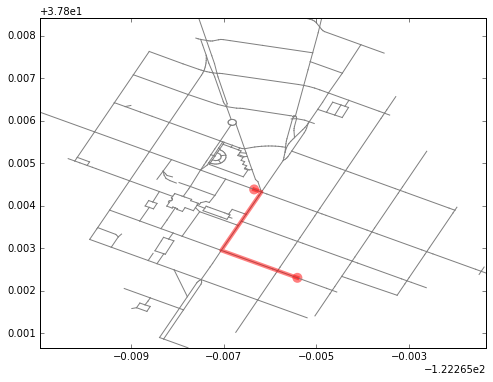

In [22]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width * bbox_aspect_ratio))
for u, v, edge_details in G.edges(data=True):
    x = (G.node[u]['lon'], G.node[v]['lon'])
    y = (G.node[u]['lat'], G.node[v]['lat'])
    ax.plot(x, y, color='gray', linewidth=1, alpha=1)

ax.scatter(origin_destination_lons, origin_destination_lats, s=100, c='r', alpha=0.5, edgecolor='none')
ax.plot(path_lons, path_lats, color='r', linewidth=4, alpha=0.5)
ax.set_ylim((ymin, ymax))
ax.set_xlim((xmin, xmax))
plt.show()

## Plot network path from one lat-long to another

In [23]:
origin_point = (ymax, xmax)
origin_node = osmnx.get_nearest_node(G, origin_point)
origin_node

824

In [24]:
destination_point = (ymin, xmin)
destination_node = osmnx.get_nearest_node(G, destination_point)
destination_node

982

In [25]:
# use weight='length' to find the shortest spatial path, otherwise it treats each edge as weight=1
shortest_path = nx.shortest_path(G, origin_node, destination_node, weight='length')
str(shortest_path)

'[824, 172, 187, 377, 761, 772, 409, 279, 128, 346, 42, 39, 53, 972, 40, 351, 72, 110, 368, 770, 705, 989, 239, 610, 173, 4, 358, 869, 205, 93, 548, 1021, 969, 497, 675, 415, 425, 982]'

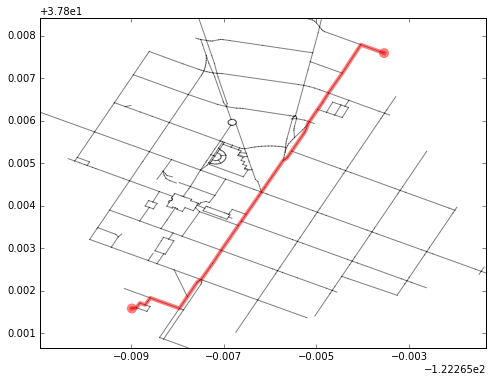

In [26]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width * bbox_aspect_ratio))
for u, v, edge_details in G.edges(data=True):
    x = (G.node[u]['lon'], G.node[v]['lon'])
    y = (G.node[u]['lat'], G.node[v]['lat'])
    ax.plot(x, y, color='k', linewidth=1, alpha=0.5)

# plot the origin and desination nodes as big red dots
origin_destination_node_lats = (G.node[origin_node]['lat'], G.node[destination_node]['lat'])
origin_destination_node_lons = (G.node[origin_node]['lon'], G.node[destination_node]['lon'])
ax.scatter(origin_destination_node_lons, origin_destination_node_lats, s=100, c='r', alpha=0.5, edgecolor='none')

# plot the shortest path as a thick red line
path_lats = [float(G.node[node_id]['lat']) for node_id in shortest_path]
path_lons = [float(G.node[node_id]['lon']) for node_id in shortest_path]
ax.plot(path_lons, path_lats, color='r', linewidth=4, alpha=0.5)

# plot the origin/destination points and their paths to the nearest node, in blue
#ax.scatter(origin_point[1], origin_point[0], s=200, c='m', alpha=0.5, edgecolor='none')
#ax.scatter(destination_point[1], destination_point[0], s=200, c='m', alpha=0.5, edgecolor='none')
#ax.plot([origin_point[1], G.node[origin_node]['lon']], 
#        [origin_point[0], G.node[origin_node]['lat']], 
#        color='m', linewidth=2, alpha=0.5)
#ax.plot([destination_point[1], G.node[destination_node]['lon']], 
#        [destination_point[0], G.node[destination_node]['lat']], 
#        color='m', linewidth=2, alpha=0.5)

ax.set_ylim((ymin, ymax))
ax.set_xlim((xmin, xmax))
plt.show()

In [27]:
# if node has degree exactly 2 (except for elbows??), find the neighbors, make an edge between them, delete original node
#degree = G.degree()
#to_remove = [n for n in degree if degree[n] == 2]
#G.remove_nodes_from(to_remove)